<a href="https://colab.research.google.com/github/ContiPaolo/Multifidelity-Tutorial/blob/main/MF_POD_Burger's1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-fidelity reduced-order modeling on Groundwater's flow - Darcy equation**

#### We aim to create a reduced-order surrogate model that enables the efficient recovery of high-fidelities solutions over time and parameter variations, starting from their low-fidelity counterparts.

#### We consider a data-driven strategy that combines dimensionality reduction via Proper Orthogonal Decompostion (POD) with multi-fidelity long-short term memory neural (LSTM) network surrogates.


#### (1) **Generation of multi-fidelity dataset**
#### (2) **Dimensionality reduction via POD**
#### (3) **Computing reduced-coordinates via projection**
#### (4) **Training LSTM neural network surrogate model**



#### Import libraries

In [10]:
import numpy as np
#import matplotlib as plt
from matplotlib import pyplot as plt
import pandas as pd 
from tensorflow.keras.optimizers import Adam,Nadam,Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model
from sklearn.utils import extmath

#######################     CONFIGURATIONS     ##########################
seed = 29
train = True
save = True

#### Problem setup
Consider steady groundwater flow in a confined, inhomogeneous aquifer which occupies the domain $\Omega$ with boundary $\Gamma$. 
Assuming that water is incompressible, the governing equations for groundwater flow can be written as the scalar elliptic partial differential equation:
$$
-\nabla \cdot(-T(\mathbf{x}) \nabla h(\mathbf{x}))=g(\mathbf{x}) \text { for all } \quad \mathbf{x} \in \Omega
$$
subject to boundary conditions on $\Gamma=\Gamma_N \cup \Gamma_D$ defined by the constraint equations
$$
h(\mathbf{x})=h_D(\mathbf{x}) \quad \text { on } \Gamma_D \quad \text { and } \quad(-T(\mathbf{x}) \nabla h(\mathbf{x})) \cdot \boldsymbol{n}=q_N(\mathbf{x}) \quad \text { on } \Gamma_N .
$$

Here $T(\mathbf{x})$ is the heterogeneous, depth-integrated transmissivity, $h(\mathbf{x})$ is hydraulic head, $h_D(\mathbf{x})$ is fixed hydraulic head at boundaries with Dirichlet constraints, $g(\mathbf{x})$ is fluid sources and sinks, $q(\mathbf{x})$ is Darcy velocity, $q_N(\mathbf{x})$ is Darcy velocity across boundaries with Neumann constraints and $\Gamma_D \subset \partial \Omega$ and $\Gamma_N \subset \partial \Omega$ define the boundaries comprising of Dirichlet and Neumann conditions, respectively. Following standard FEM practice (see e.g. [19]), eq. (1) is converted into weak form by multiplying by an appropriate test function $w \in H^1(\Omega)$ and integrating by parts, so that
$$
\int_{\Omega} \nabla w \cdot(T(\mathbf{x}) \nabla h) d \mathbf{x}+\int_{\Gamma_N} w q_N(\mathbf{x}) d s=\int_{\Omega} w g(\mathbf{x}) d \mathbf{x}, \quad \forall w \in H^1(\Omega),
$$
where $H^1(\Omega)$ is the Hilbert space of weakly differentiable functions on $\Omega$. To approximate the hydraulic head solution $h(\boldsymbol{x})$, a finite element space $V_\tau \subset H^1(\Omega)$ on a finite element mesh $\mathcal{Q}_\tau(\Omega)$. This is defined by a basis of piecewise linear Lagrange polynomials $\left\{\phi_i(\mathbf{x})\right\}_{i=1}^M$, associated with each of the $M$ finite element nodes. As a result (3) can be rewritten as a system of sparse linear equations
$$
\begin{aligned}
\mathbf{A h}=\mathbf{b} \quad \text { where } \quad A_{i j} & =\int_{\Omega} \nabla \phi_i \cdot T(\mathbf{x}) \nabla \phi_j(\mathbf{x}) d \mathbf{x} \text { and } \\
b_i & =\int_{\Omega} \phi_i(\mathbf{x}) g(\mathbf{x}) d \mathbf{x}-\int_{\Gamma_N} \phi_i(\mathbf{x}) q_N(\mathbf{x}) d s
\end{aligned}
$$
where $\mathbf{A} \in \mathbb{R}^{M \times M}$ and $\mathbf{b} \in \mathbb{R}^M$ are the global stiffness matrix and load vector, respectively. The vector $\mathbf{h}:=\left[h_1, h_2, \ldots, h_M\right] \in \mathbb{R}^M$ is the solution vector of hydraulic head at each node within the finite element mesh so that $h(\mathbf{x})=\sum_{i=1}^M h_i \phi_i(\mathbf{x})$. In our numerical experiments, these equations are solved using the open source general-purpose FEM framework FEniCS. While there are well-established groundwater simulation software packages available, such as MODFLOW  and FEFLOW [19], FEniCS was chosen because of its flexibility and ease of integration with other software and analysis codes.


# DATASET 
The dataset has been developed using fenics library, it is composed of 64000 samples divided in 90% training and 10% testing.\
The input (or X) are the 64 first component of the Karhunen-Loève (KL) decompositions. \
These eigenmodes allow to paratetrize a random field in the most accurate way.

In [11]:
X_train = pd.read_csv('./data/X_train.csv').values
y_train = pd.read_csv('./data/y_train.csv').values

X_test = pd.read_csv('./data/X_test.csv').values
y_test = pd.read_csv('./data/y_test.csv').values

The output: 25 sensors are used to record the hydraulic pressure in the domain $\Omega$ \
The sensors are distributed on a grid with positions [0.1, 0.3, 0.5, 0.7, 0.9]



In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_norm = scaler.fit_transform(y_train)

#### (2) Dimensionality reduction via POD

I want $A \in R^{m\times n }$ with m dimention of output and n number of samples  

In [ ]:
n = 10000
y_t = y_train[0:n,:].T
y_t.shape

(25, 10000)

In [14]:
U, S, Vh = np.linalg.svd(y_t)
U.shape, S.shape, Vh.shape

((25, 25), (25,), (10000, 10000))

Understand how many components would be useful to retain 

S is: [288.94129557  22.89029679  16.02475836  12.22996171  11.33382382
   7.47981836   7.43224357   6.70035626   6.6886781    5.54436742
   5.41351805   5.19717997   4.78607117   4.15891058   3.98016847
   3.87193862   3.85345148   3.34402812   3.01580599   2.79710465
   2.7700708    2.63449657   2.39211637   2.06851443   1.8055892 ]
[0.66065687 0.71299494 0.74963514 0.77759864 0.80351313 0.82061555
 0.83760918 0.85292937 0.86822286 0.88089992 0.89327779 0.90516101
 0.91610424 0.92561348 0.93471403 0.94356712 0.95237794 0.96002397
 0.96691954 0.97331504 0.97964874 0.98567245 0.99114196 0.99587157
 1.        ]


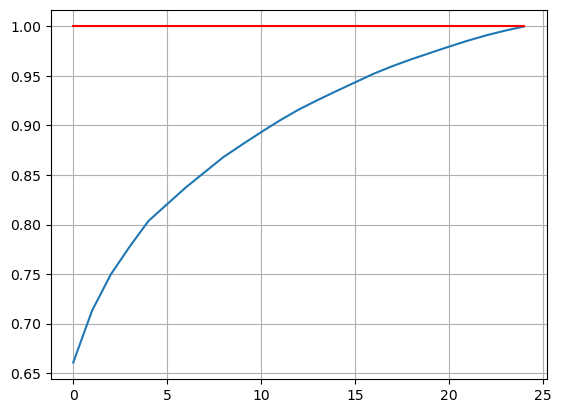

In [5]:
print('S is:', S)
v = np.cumsum(S)/np.sum(S)
print(v)
plt.plot(v, '-')
plt.grid()
plt.plot(np.ones(25), 'red')
plt.show()

There is no evident elbow that makes the choise on the number of component to retain obvious\

We choose to keep the first n = 3 components

### Visualize the components 

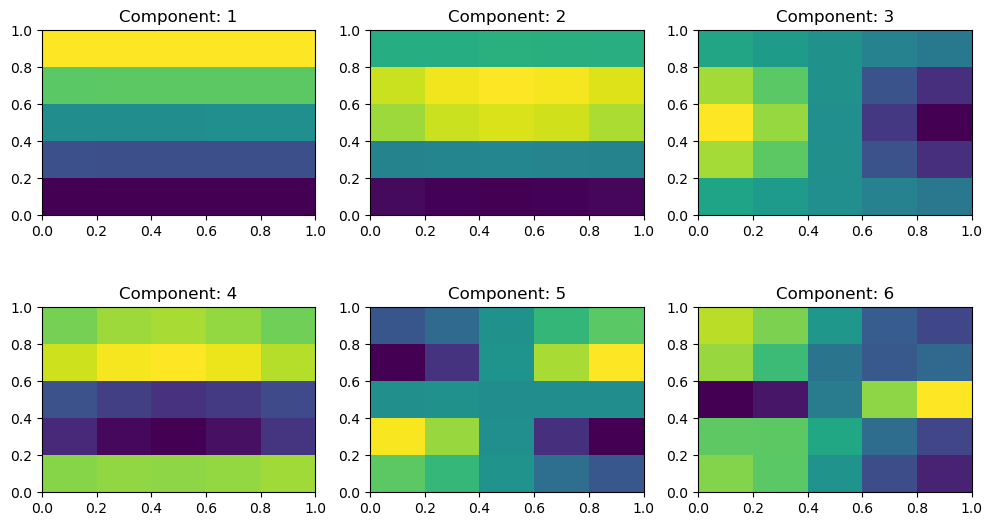

In [6]:
# Define the sampling points.
x_data = y_data = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
# Grid to plot the basis 
X,Y = np.meshgrid(x_data, y_data)

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(hspace=0.5)
for mode in range(6):
    ax = fig.add_subplot(231 + mode)
    plt.pcolormesh(X, Y, U[:,mode].reshape((5,5)))
    ax.title.set_text('Component: ' + str(mode+1))
plt.show()

#### (3) Computing reduced-coordinates via projection

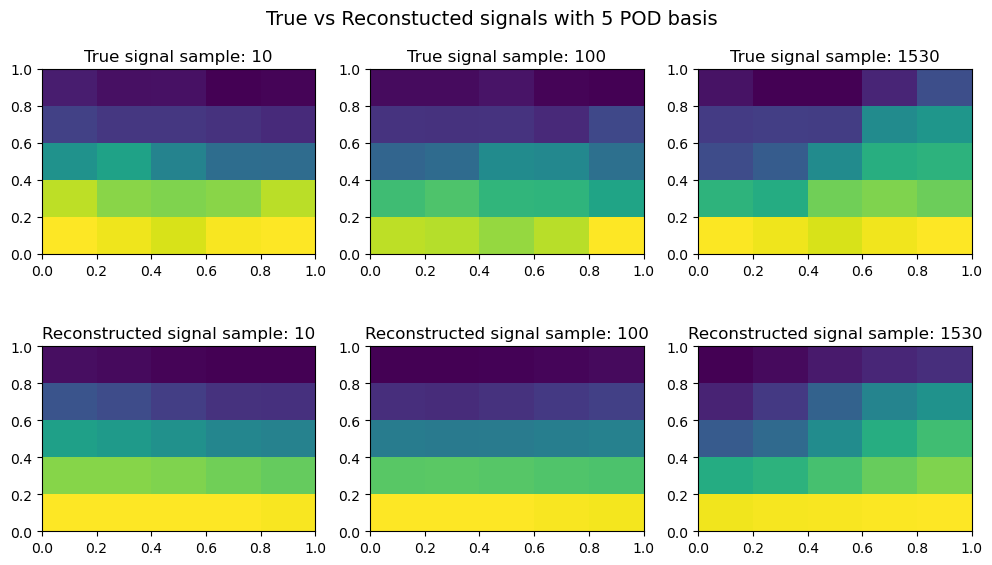

In [15]:
#########################   PROJECTION ONTO POD BASIS    ##########################
n_comp = 5 # number of components to retain 

basis = U[:,0:n_comp]
y_train_pod = y_train @ basis
y_test_pod = y_test @ basis

# Define the sampling points.
x_data = y_data = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
# Grid to plot the basis 
X,Y = np.meshgrid(x_data, y_data)

samples = [ 10, 100, 1530]
#Plot POD coefficients: LF vs HF
fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(hspace=0.5)
title = 'True vs Reconstucted signals with '+ str(n_comp)+' POD basis'
fig.suptitle(title, fontsize=14)
for mode in range(3):
    ax = fig.add_subplot(231 + mode)
    plt.pcolormesh(X, Y, y_train[mode,:].reshape((5,5)))
    ax.title.set_text('True signal sample: ' + str(samples[mode]))
    ax = fig.add_subplot(231 + mode+3)
    recontructed_sample = y_train_pod[mode,:].reshape((1,n_comp))@basis.T
    plt.pcolormesh(X, Y, recontructed_sample.reshape((5,5)))
    ax.title.set_text('Reconstructed signal sample: ' + str(samples[mode]))
plt.show()

#### (4ii) Training Fully connected neural network surrogate model

Before introducing the POD in the creation of the model, let us explore how a direct (and therefore simpler) map would perform in this environment \

Let us first try to create a map $T(x) \rightarrow u(x)$ 

Create a NN that takes in inuput the 64 eigenvalues of the transittivity field and returns the hydraulic pressure in the 25 points where the sensors are located 


In [16]:
Training = True


# Define the learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return max(lr * 0.99, 1e-4)

# Initialize the neural network model
model = Sequential()

# Add layers to the model
model.add(Dense(64, input_shape=(64,), activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(25, activation='linear'))

if Training:
    # Compile the model
    initial_learning_rate = 0.03
    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define the learning rate scheduler callback
    lr_scheduler = LearningRateScheduler(scheduler)

    # Train the model
    history = model.fit(X_train, y_train, 
                    epochs=1500, 
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lr_scheduler])
    
    model.save('./models/model_NN2.keras')

model = load_model('./models/model_NN2.keras')



Epoch 1/1500


/Users/lucacaroselli/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step - loss: 0.0215 - val_loss: 0.0013 - learning_rate: 0.0300
Epoch 2/1500
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 0.0014 - val_loss: 0.0014 - learning_rate: 0.0300
Epoch 3/1500
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 0.0015 - val_loss: 0.0019 - learning_rate: 0.0300
Epoch 4/1500
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 0.0019 - val_loss: 0.0019 - learning_rate: 0.0300
Epoch 5/1500
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 0.0025 - val_loss: 0.0017 - learning_rate: 0.0300
Epoch 6/1500
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 0.0021 - val_loss: 0.0028 - learning_rate: 0.0300
Epoch 7/1500
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 0.0025 - val_loss: 0.0035 - learning_rate: 0.0300
Epoch 8/1500
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 0.0027 - val_loss: 0.0027 - learning_rate: 0.0300
Epoch 9/1500
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 0.0027 - val_loss: 0.0026 - learning_

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - loss: 5.3186e-04
Test accuracy: 0.0005323761724866927


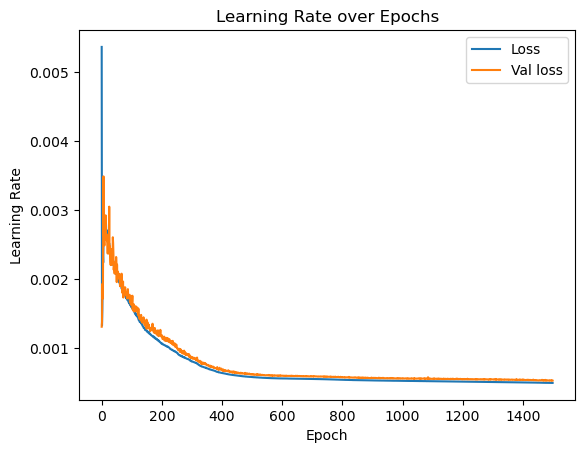

In [17]:
# Evaluate the model on the test set
test_loss = model.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Test accuracy: {test_loss}")

# Optional: Plotting the learning rate and accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Epochs')
plt.legend()
plt.show()



Se how it is able to prodict 

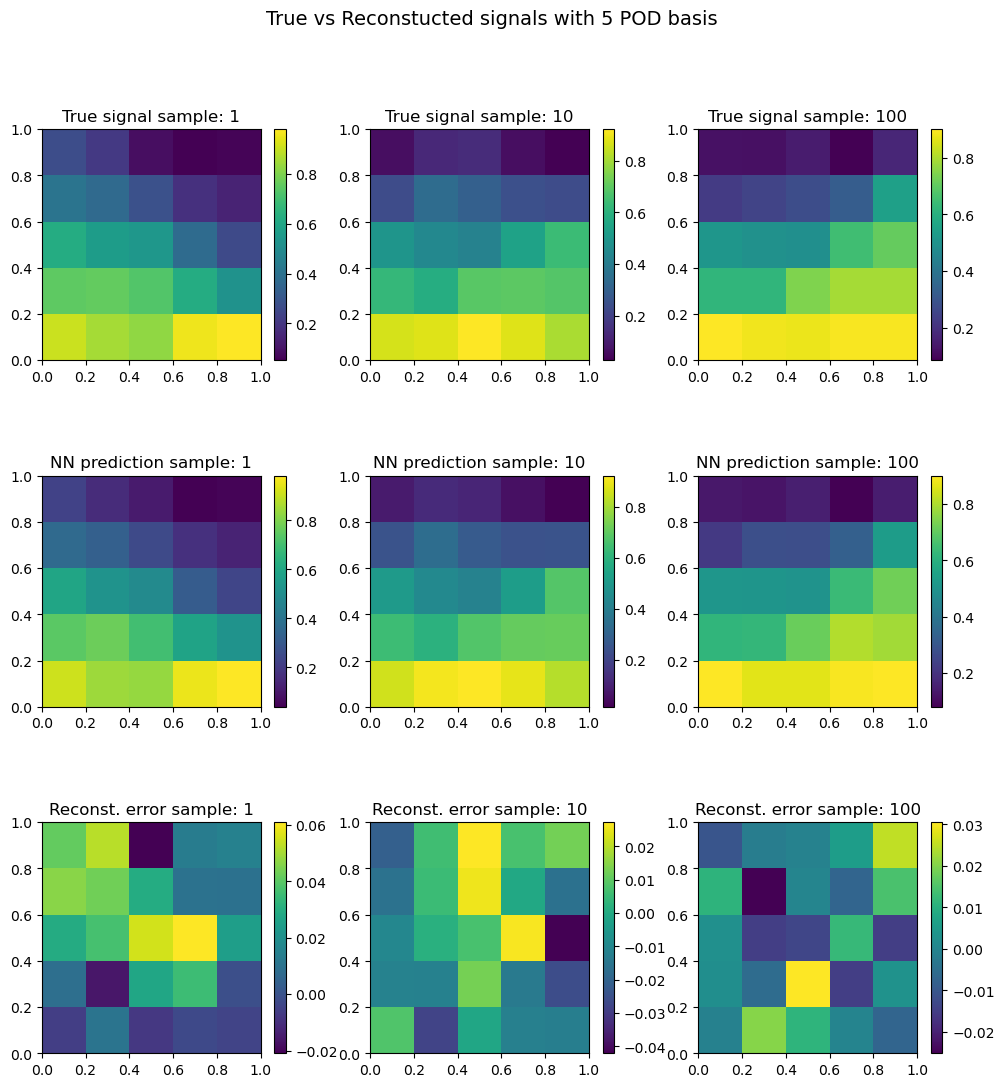

In [18]:
# Define the sampling points.
x_data = y_data = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
# Grid to plot the basis 
X,Y = np.meshgrid(x_data, y_data)

samples = [ 1, 10, 100]
#Plot POD coefficients: LF vs HF
fig = plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=0.5)
title = 'True vs Reconstucted signals with '+ str(n_comp)+' POD basis'
fig.suptitle(title, fontsize=14)

for mode in range(3):
    ax = fig.add_subplot(331 + mode)
    pcm = plt.pcolormesh(X, Y, y_test[mode, :].reshape((5, 5)))
    ax.title.set_text('True signal sample: ' + str(samples[mode]))
    plt.colorbar(pcm, ax=ax)
    
    ax = fig.add_subplot(331 + mode + 3)
    reconstructed_sample = np.array(model(X_test[mode, :].reshape((1, 64)))).reshape((5, 5))
    err = y_test[mode, :].reshape(5, 5) - reconstructed_sample
    pcm = plt.pcolormesh(X, Y, reconstructed_sample.reshape((5, 5)))
    ax.title.set_text('NN prediction sample: ' + str(samples[mode]))
    plt.colorbar(pcm, ax=ax)
    
    ax = fig.add_subplot(331 + mode + 6)
    pcm = plt.pcolormesh(X, Y, err)
    ax.title.set_text('Reconst. error sample: ' + str(samples[mode]))
    plt.colorbar(pcm, ax=ax)


### Model POD


Let us now try introducing the POD approximation.

In this second scenario the goal would be to create a map $T(x) \rightarrow \theta_{POD}$

Given the transmissivity the goal is to predict the POD coefficients of the solution 

In [73]:
Training = True 


# Define the learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return max(lr * 0.99, 1e-4)

# Initialize the neural network model
model_pod = Sequential()

# Add layers to the model
model_pod.add(Dense(64, input_shape=(64,), activation='relu'))
model_pod.add(Dense(n_comp, activation='relu'))

if Training:
    # Compile the model
    initial_learning_rate = 0.05
    optimizer = Adam(learning_rate=initial_learning_rate)
    model_pod.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define the learning rate scheduler callback
    lr_scheduler = LearningRateScheduler(scheduler)

    # Train the model
    history = model_pod.fit(X_train, -y_train_pod, 
                    epochs=500, 
                    batch_size=64, 
                    validation_data=(X_test, -y_test_pod), 
                    callbacks=[lr_scheduler])
    
    model_pod.save('./models/model_NN_POD3.keras')

model_pod = load_model('./models/model_NN_POD3.keras')

Epoch 1/500
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 402us/step - loss: 0.0990 - val_loss: 0.0222 - learning_rate: 0.0500
Epoch 2/500
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 0.0226 - val_loss: 0.0221 - learning_rate: 0.0500
Epoch 3/500
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 0.0224 - val_loss: 0.0222 - learning_rate: 0.0500
Epoch 4/500
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 0.0225 - val_loss: 0.0226 - learning_rate: 0.0500
Epoch 5/500
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 0.0227 - val_loss: 0.0223 - learning_rate: 0.0500
Epoch 6/500
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 0.0228 - val_loss: 0.0222 - learning_rate: 0.0500
Epoch 7/500
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 0.0232 - val_loss: 0.0576 - learning_rate: 0.0500
Epoch 8/500
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 0.0306 - val_loss: 0.0226 - learning_rate: 0.0500
Epoch 9/500
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 0.0231 - val_loss: 0.0223 - learn

In [ ]:
print(t.shape) 
print(re.shape) 

t_grid_lstm, re_grid_lstm = np.meshgrid(t, re)

print(re_grid_lstm.shape)

# Train
t_grid_lstm, re_grid_lstm = np.meshgrid(t, re)
input_train = np.concatenate((t_grid_lstm[:,:,np.newaxis], re_grid_lstm[:,:,np.newaxis], ulf_train), axis = 2)
output_train = uhf_train
print(input_train.shape)
print(ulf_train.shape)
print(uhf_train.shape)


(151,)
(20,)
(20, 151)
(20, 151, 18)
(20, 151, 16)
(20, 151, 16)


In [ ]:
# Reshape to make data suitable to LSTM network

# Train
t_grid_lstm, re_grid_lstm = np.meshgrid(t, re)
input_train = np.concatenate((t_grid_lstm[:,:,np.newaxis], re_grid_lstm[:,:,np.newaxis], ulf_train), axis = 2)
output_train = uhf_train

#Test
t_grid_lstm_test, re_grid_lstm_test = np.meshgrid(t, re_test)
input_test = np.concatenate((t_grid_lstm_test[:,:,np.newaxis], re_grid_lstm_test[:,:,np.newaxis], ulf_test), axis = 2)
output_test = uhf_test

#########################   LSTM NN HYPERPARAMETERS    ##########################
params_NN = { 'lay': 1,
             'nodes': 64,
             'lr':  1e-3,
             'opti': 'Adamax',
             'sequence_freq': 2,
             'sequence_length': 10,
             'epochs':  500,
             'patience' : 50,
             'dropout' : 0.1}

############################   TRAINING/LOADING    ##############################

if train:
    #Split the data into subsequences
    sequence_length = int(params_NN['sequence_length'])
    sequence_freq = int(params_NN['sequence_freq'])
    input_train_seq, output_train_seq = sliding_windows(input_train, output_train, sequence_length, sequence_freq)

    #Create the LSTM NN model
    model = create_model(params_NN, dim_input = n_POD + 2, dim_output = n_POD) #dim_input = param + time + POD modes ==  1 + 1 + n_POD

    #Train the model
    callback = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=params_NN['patience'], restore_best_weights=True)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism() # for reproducibility
    hist = model.fit(input_train_seq, output_train_seq, epochs=params_NN['epochs'], verbose = 1, callbacks=[callback])

else:
    name = './models/MF_POD_model'
    model = tf.keras.models.load_model(name)
if save:
    name = './models/MF_POD_model_new'
    model.save(name)

Epoch 1/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1028 - mse: 0.1028
Epoch 2/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0374 - mse: 0.0374
Epoch 3/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0236 - mse: 0.0236
Epoch 4/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0180 - mse: 0.0180
Epoch 5/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0150 - mse: 0.0150
Epoch 6/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0129 - mse: 0.0129
Epoch 7/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0112 - mse: 0.0112
Epoch 8/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0099 - mse: 0.0099
Epoch 9/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088 - mse: 0.0088
Epoch 10/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - mse: 0.0080
Epoch 11/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - mse: 0.0072
Epoch 12/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - mse: 0.0066
Epoch 13/500
45/45 ━━━━━━━━━━━━━━━━━━

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `tf.saved_model.save()` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=./models/MF_POD_model_new.

### Prediction for new parameters

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


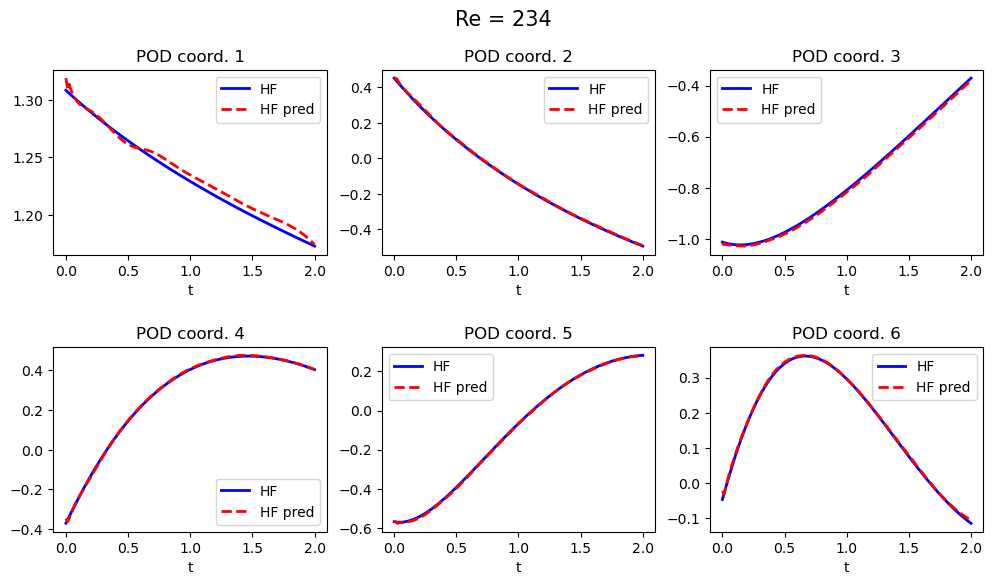

In [ ]:
#########################   PREDICTION    ##########################

# Predictions on test data
output_pred = model.predict(input_test)

# Plot predicted POD coordinates
ind_test = [0] # Re = 235
for ind_re in ind_test:
    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle('Re = ' + str(int(denormalize(re_test[ind_re]))), fontsize=15)
    for mode in range(6):
      plt.subplot(231 + mode)
      plt.plot(t, output_test[ind_re,:,mode],'b-', label = 'HF', linewidth = 2)
      plt.plot(t, output_pred[ind_re, :, mode], 'r--', label = 'HF pred', linewidth = 2)
      plt.xlabel('t')
      plt.title('POD coord. ' + str(mode+1))
      plt.legend()
    plt.show()

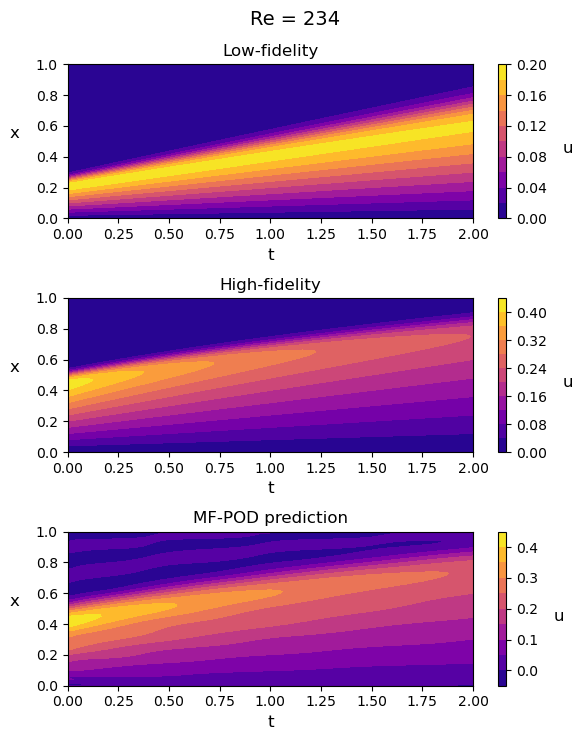

In [ ]:
#Reconstruct solution

u_pred = output_pred @ basis.T

#Compare with HF solution
for ind_re in ind_test:
  fig = plt.figure(figsize=(6, 7.5))
  plt.suptitle('Re = ' + str(int(denormalize(re_test[ind_re]))), fontsize = 14)
  ax = fig.add_subplot(311)
  surf = ax.contourf(t_grid, x_grid, u_lf_test[ind_re].T, cmap='plasma', levels=10)
  plt.xlabel('t', fontsize=12)
  plt.ylabel('x', fontsize=12, labelpad=15, rotation = 0)
  cbar = fig.colorbar(surf, ax=ax)
  cbar.ax.set_ylabel('u', fontsize=12, labelpad=15, rotation = 0)
  plt.title('Low-fidelity', fontsize=12)
  ax = fig.add_subplot(312)
  surf = ax.contourf(t_grid, x_grid, u_hf_test[ind_re].T, cmap='plasma', levels=10)
  plt.xlabel('t', fontsize=12)
  plt.ylabel('x', fontsize=12, labelpad=15, rotation = 0)
  cbar = fig.colorbar(surf, ax=ax)
  cbar.ax.set_ylabel('u', fontsize=12, labelpad=15, rotation = 0)
  plt.title('High-fidelity', fontsize=12)
  ax = fig.add_subplot(313)
  surf = ax.contourf(t_grid, x_grid, u_pred[ind_re].T, cmap='plasma', levels=10)
  plt.xlabel('t', fontsize=12)
  plt.ylabel('x', fontsize=12, labelpad=15, rotation = 0)
  cbar = fig.colorbar(surf, ax=ax)
  cbar.ax.set_ylabel('u', fontsize=12, labelpad=15, rotation = 0)
  plt.title('MF-POD prediction', fontsize=12)
  plt.tight_layout()
  plt.show()

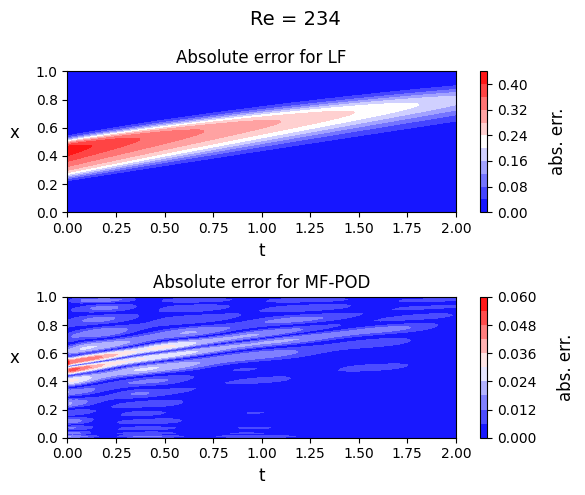

In [ ]:
#Compute and plot errors
rel_err_lf = np.linalg.norm(u_lf_test - u_hf_test)/np.linalg.norm(u_hf_test[ind_re])
rel_err_pred = np.linalg.norm(u_pred - u_hf_test)/np.linalg.norm(u_hf_test[ind_re])

abs_err_lf = np.abs(u_lf_test - u_hf_test)
abs_err_pred = np.abs(u_pred - u_hf_test)

for ind_re in ind_test:
  fig = plt.figure(figsize=(6, 5))
  plt.suptitle('Re = ' + str(int(denormalize(re_test[ind_re]))), fontsize = 14)
  ax = fig.add_subplot(211)
  surf = ax.contourf(t_grid, x_grid, abs_err_lf[ind_re].T, cmap='bwr', levels=10)
  cbar = fig.colorbar(surf, ax=ax)
  cbar.ax.set_ylabel('abs. err.', fontsize=12, labelpad=15)
  plt.xlabel('t', fontsize=12)
  plt.ylabel('x', fontsize=12, labelpad=15, rotation = 0)
  plt.title('Absolute error for LF', fontsize=12)
  ax = fig.add_subplot(212)
  surf = ax.contourf(t_grid, x_grid, abs_err_pred[ind_re].T, cmap='bwr', levels=10)
  cbar = fig.colorbar(surf, ax=ax)
  cbar.ax.set_ylabel('abs. err.', fontsize=12, labelpad=15)
  plt.xlabel('t', fontsize=12)
  plt.ylabel('x', fontsize=12, labelpad=15, rotation = 0)
  plt.title('Absolute error for MF-POD', fontsize=12)
  plt.tight_layout()
  plt.show()


### **References**
</br>

[1] **Conti P, Guo M, Manzoni A, Brunton S L, Kutz J N**. [Multi-fidelity reduced-order modeling](https://arxiv.org/abs/2309.00325), *preprint arXiv:2308.01602* (2023).

[2] **Conti P, Mengwu G, Manzoni A, Hesthaven J S**.  [Multi-fidelity surrogate modeling using long short-term memory networks](https://www.sciencedirect.com/science/article/abs/pii/S0045782522007678?via%3Dihub), *CMAME* (2023).

[3] **Mengwu G, Manzoni A, Amendt M, Conti P, Hesthaven J S**.  [Multi-fidelity regression using artificial neural networks: Efficient approximation of parameter-dependent output quantities](https://www.sciencedirect.com/science/article/pii/S0045782521006411?via%3Dihub), *CMAME* (2022).


#### **Extra**
You can find the code for a reaction-diffusion problem at the [Multi-fidelity POD repository](https://github.com/ContiPaolo/MultiFidelity_POD)

⭐ Leave a star to the github repo if you enojyed :)